In [ ]:
## CODE 1 Optimized
 
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from torchvision.utils import save_image
from PIL import Image
import os
import wandb
import cv2
import dlib
import numpy as np
import time
from torch.cuda.amp import GradScaler, autocast
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
 
# Initialize wandb
wandb.init(project="")
 
# Define paths
shape_predictor_path = r""
neutral_folder = r''
anger_folder = r''
aligned_neutral = r''
aligned_anger = r''
 
# Create preprocessed directories if they don't exist
os.makedirs(aligned_neutral, exist_ok=True)
os.makedirs(aligned_anger, exist_ok=True)
 
# Initialize dlib's face detector and landmark predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(shape_predictor_path)
 
# Block 2: Face Alignment Functions
 
def align_and_save_faces(source_folder, target_folder):
    """Preprocess and save aligned faces to target folder"""
    if len(os.listdir(target_folder)) > 0:
        return  # Skip if already processed
 
    for img_name in os.listdir(source_folder):
        img_path = os.path.join(source_folder, img_name)
        image = Image.open(img_path).convert('RGB')
        aligned = align_face(image)
        if aligned:
            aligned.save(os.path.join(target_folder, img_name))
 
def align_face(image):
    """Align face using facial landmarks"""
    try:
        image_np = np.array(image)
        gray = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)
        faces = detector(gray, 1)
        if not faces:
            return None
        landmarks = predictor(gray, faces[0])
        landmarks = np.array([[p.x, p.y] for p in landmarks.parts()])
        desired_left_eye = (0.35, 0.35)
        desired_face_width = 256
        desired_face_height = 256
        left_eye_center = landmarks[36:42].mean(axis=0)
        right_eye_center = landmarks[42:48].mean(axis=0)
        dY = right_eye_center[1] - left_eye_center[1]
        dX = right_eye_center[0] - left_eye_center[0]
        angle = np.degrees(np.arctan2(dY, dX))
        dist = np.sqrt((dX ** 2) + (dY ** 2))
        desired_dist = (1.0 - 2 * desired_left_eye[0]) * desired_face_width
        scale = desired_dist / dist
        eyes_center = ((left_eye_center[0] + right_eye_center[0]) // 2,
                       (left_eye_center[1] + right_eye_center[1]) // 2)
        M = cv2.getRotationMatrix2D(eyes_center, angle, scale)
        tX = desired_face_width * 0.5
        tY = desired_face_height * desired_left_eye[1]
        M[0, 2] += (tX - eyes_center[0])
        M[1, 2] += (tY - eyes_center[1])
        aligned_face = cv2.warpAffine(image_np, M, (desired_face_width, desired_face_height), flags=cv2.INTER_CUBIC)
        return Image.fromarray(aligned_face)
    except Exception as e:
        print(f"Error processing image: {e}")
        return None
 
# Preprocess datasets once before training
print("Preprocessing datasets...")
align_and_save_faces(neutral_folder, aligned_neutral)
align_and_save_faces(anger_folder, aligned_anger)
 
# Block 3: Dataset and DataLoader
 
class PreprocessedDataset(Dataset):

    """Dataset that loads preprocessed images"""

    def __init__(self, folder, transform=None):

        self.image_paths = [os.path.join(folder, f) for f in os.listdir(folder)]

        self.transform = transform
 
    def __len__(self):

        return len(self.image_paths)
 
    def __getitem__(self, idx):

        image = Image.open(self.image_paths[idx]).convert('RGB')

        if self.transform:

            image = np.array(image) # Convert PIL image to numpy array

            image = self.transform(image=image)['image'] # Pass as named argument

        return image
 
 
# Define transformations with Albumentations
transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Rotate(limit=15, p=0.3),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2(),
])
 
# Create datasets and dataloaders
print("Creating dataloaders...")
neutral_dataset = PreprocessedDataset(aligned_neutral, transform)
anger_dataset = PreprocessedDataset(aligned_anger, transform)
 
neutral_dataloader = DataLoader(
    neutral_dataset,
    batch_size=16,
    shuffle=True,
    pin_memory=True
)
 
anger_dataloader = DataLoader(
    anger_dataset,
    batch_size=16,
    shuffle=True,
    pin_memory=True
)
 
# Block 4: Generator and Discriminator Models
 

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.down1 = self.conv_block(3, 64, normalize=False)
        self.down2 = self.conv_block(64, 128)
        self.down3 = self.conv_block(128, 256)
        self.down4 = self.conv_block(256, 512)
        self.down5 = self.conv_block(512, 512)
        self.up1 = self.deconv_block(512, 512)
        self.up2 = self.deconv_block(1024, 256)
        self.up3 = self.deconv_block(512, 128)
        self.up4 = self.deconv_block(256, 64)
        self.up5 = self.deconv_block(128, 3, normalize=False, activation=nn.Tanh())
        self.apply(self._init_weights)
 
    def conv_block(self, in_channels, out_channels, normalize=True, activation=nn.LeakyReLU(0.2)):
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)]
        if normalize:
            layers.append(nn.InstanceNorm2d(out_channels))
        layers.append(activation)
        return nn.Sequential(*layers)
 
    def deconv_block(self, in_channels, out_channels, normalize=True, activation=nn.ReLU()):
        layers = [nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)]
        if normalize:
            layers.append(nn.InstanceNorm2d(out_channels))
        layers.append(activation)
        return nn.Sequential(*layers)
 
    def _init_weights(self, m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
            init.normal_(m.weight, 0.0, 0.02)
            if m.bias is not None:
                init.constant_(m.bias, 0.0)
 
    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        u1 = self.up1(d5)
        u2 = self.up2(torch.cat([u1, d4], dim=1))
        u3 = self.up3(torch.cat([u2, d3], dim=1))
        u4 = self.up4(torch.cat([u3, d2], dim=1))
        u5 = self.up5(torch.cat([u4, d1], dim=1))
        return u5
 
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=1, padding=1),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1),
        )
        self.apply(self._init_weights)
 
    def _init_weights(self, m):
        if isinstance(m, nn.Conv2d):
            init.normal_(m.weight, 0.0, 0.02)
            if m.bias is not None:
                init.constant_(m.bias, 0.0)
 
    def forward(self, x):
        return self.model(x)
 
# Block 5: Training Setup
 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
G_neutralToAnger = Generator().to(device)
G_AngerToneutral = Generator().to(device)
D_neutral = Discriminator().to(device)
D_Anger = Discriminator().to(device)
 
G_optimizer = optim.Adam(list(G_neutralToAnger.parameters()) + list(G_AngerToneutral.parameters()), lr=0.00005, betas=(0.5, 0.999))           ##################
D_optimizer = optim.Adam(list(D_neutral.parameters()) + list(D_Anger.parameters()), lr=0.00005, betas=(0.5, 0.999))            ##################
 
criterion_gan = nn.MSELoss()
criterion_cycle = nn.L1Loss()
criterion_identity = nn.L1Loss()
 
vgg = models.vgg19(pretrained=True).features.to(device).eval()
for param in vgg.parameters():
    param.requires_grad = False
 
def perceptual_loss(generated, real, vgg_model):
    def extract_features(x, vgg_model):
        features = []
        for layer_num, layer in enumerate(vgg_model):
            x = layer(x)
            if layer_num in [2, 7, 12, 21, 30]:
                features.append(x)
        return features
 
    generated_features = extract_features(generated, vgg_model)
    real_features = extract_features(real, vgg_model)
    loss = 0
    for gen_feature, real_feature in zip(generated_features, real_features):
        loss += F.l1_loss(gen_feature, real_feature)
    return loss
 
scaler = GradScaler()
num_epochs = 20
lambda_cycle = 5.0
lambda_identity = 2.0
lambda_perceptual = 0.5
# lambda_cycle = 10.0
# lambda_identity = 5.0
# lambda_perceptual = 1.0
 
# Block 6: Training Loop
 
for epoch in range(num_epochs):

    epoch_start = time.time()
    print(f"\nStarting Epoch {epoch+1}/{num_epochs}")
 
    with tqdm(total=len(neutral_dataloader), desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch") as pbar:
        for i, (neutral_images, anger_images) in enumerate(zip(neutral_dataloader, anger_dataloader)):
            iter_start = time.time()
            neutral_images = neutral_images.to(device, non_blocking=True)
            anger_images = anger_images.to(device, non_blocking=True)
 
            G_neutralToAnger.zero_grad()
            G_AngerToneutral.zero_grad()
    
            with autocast():
                identity_anger = G_neutralToAnger(anger_images)
                loss_identity_anger = criterion_identity(identity_anger, anger_images)
                identity_neutral = G_AngerToneutral(neutral_images)
                loss_identity_neutral = criterion_identity(identity_neutral, neutral_images)
    
                fake_anger = G_neutralToAnger(neutral_images)
                fake_anger_pred = D_Anger(fake_anger)
                loss_gan_neutralToAnger = criterion_gan(fake_anger_pred, torch.ones_like(fake_anger_pred))
    
                fake_neutral = G_AngerToneutral(anger_images)
                fake_neutral_pred = D_neutral(fake_neutral)
                loss_gan_AngerToneutral = criterion_gan(fake_neutral_pred, torch.ones_like(fake_neutral_pred))
    
                reconstructed_neutral = G_AngerToneutral(fake_anger)
                loss_cycle_neutral = criterion_cycle(reconstructed_neutral, neutral_images)
                reconstructed_anger = G_neutralToAnger(fake_neutral)
                loss_cycle_Anger = criterion_cycle(reconstructed_anger, anger_images)
    
                loss_perceptual_anger = perceptual_loss(fake_anger, anger_images, vgg)
                loss_perceptual_neutral = perceptual_loss(fake_neutral, neutral_images, vgg)
    
                G_loss = (
                    loss_gan_neutralToAnger + loss_gan_AngerToneutral +
                    lambda_cycle * (loss_cycle_neutral + loss_cycle_Anger) +
                    lambda_identity * (loss_identity_anger + loss_identity_neutral) +
                    lambda_perceptual * (loss_perceptual_anger + loss_perceptual_neutral)
                )
    
            scaler.scale(G_loss).backward()
            scaler.step(G_optimizer)
            scaler.update()
    
            D_neutral.zero_grad()
            D_Anger.zero_grad()
    
            with autocast():
                real_neutral_pred = D_neutral(neutral_images)
                loss_real_neutral = criterion_gan(real_neutral_pred, torch.ones_like(real_neutral_pred))
                real_anger_pred = D_Anger(anger_images)
                loss_real_anger = criterion_gan(real_anger_pred, torch.ones_like(real_anger_pred))
    
                fake_neutral_pred = D_neutral(fake_neutral.detach())
                loss_fake_neutral = criterion_gan(fake_neutral_pred, torch.zeros_like(fake_neutral_pred))
                fake_anger_pred = D_Anger(fake_anger.detach())
                loss_fake_anger = criterion_gan(fake_anger_pred, torch.zeros_like(fake_anger_pred))
    
                D_loss = (loss_real_neutral + loss_fake_neutral + loss_real_anger + loss_fake_anger) / 2
    
            scaler.scale(D_loss).backward()
            scaler.step(D_optimizer)
            scaler.update()
    
            if i % 20 == 0:
                iter_time = time.time() - iter_start
                pbar.set_postfix({
                    "Time": f"{iter_time:.2f}s",
                    "G_loss": f"{G_loss.item():.4f}",
                    "D_loss": f"{D_loss.item():.4f}"
                })
 
            pbar.update(1)
 
        epoch_time = time.time() - epoch_start
        print(f"Epoch {epoch+1} completed in {epoch_time//60:.0f}m {epoch_time%60:.0f}s")
    
        wandb.log({
                "G_loss": G_loss.item(),
                "D_loss": D_loss.item(),
                "epoch": epoch,
                "step": i
            })
    
        epoch_time = time.time() - epoch_start
        print(f"Epoch {epoch+1} completed in {epoch_time//60:.0f}m {epoch_time%60:.0f}s")
    
        with torch.no_grad():
            fake_anger = G_neutralToAnger(neutral_images)
            fake_neutral = G_AngerToneutral(anger_images)
            save_image(fake_anger, f'fake_anger_epoch_{epoch+1}.png', normalize=True)
            save_image(fake_neutral, f'fake_neutral_epoch_{epoch+1}.png', normalize=True)
            wandb.log({
                "Fake anger": [wandb.Image(fake_anger[0], caption=f"Epoch {epoch+1}")],
                "Fake neutral": [wandb.Image(fake_neutral[0], caption=f"Epoch {epoch+1}")]
            })
 
# Block 7: Model Saving and Wandb Finish
 
torch.save(G_neutralToAnger.state_dict(), 'G_neutralToAnger.pth')
torch.save(G_AngerToneutral.state_dict(), 'G_AngerToneutral.pth')
torch.save(D_neutral.state_dict(), 'D_neutral.pth')
torch.save(D_Anger.state_dict(), 'D_Anger.pth')
 
wandb.finish()

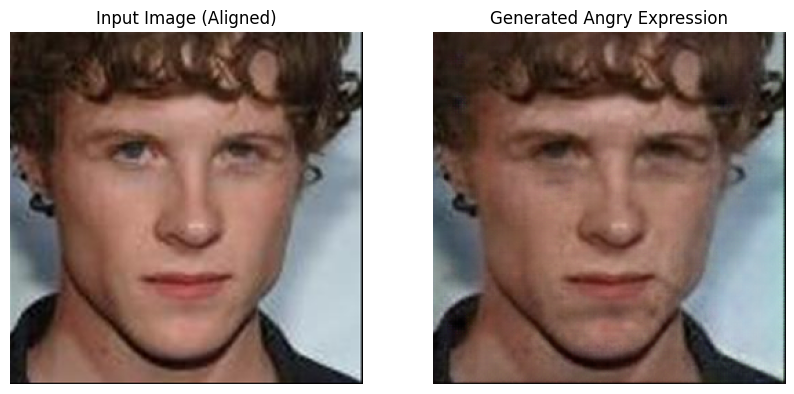

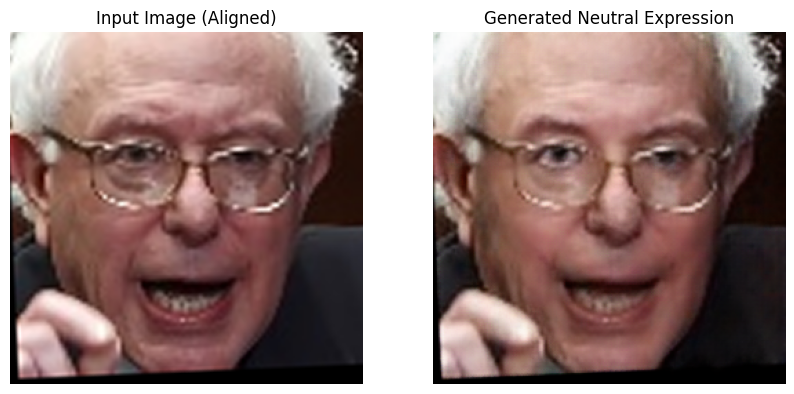

In [ ]:
import torch
from torchvision.utils import save_image
from PIL import Image
import os
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch.nn as nn
import torch.nn.init as init
import dlib  # For face detection
import cv2  # For image processing
import matplotlib.pyplot as plt  # For displaying images

# Define the Generator model (same as in the training code)
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.down1 = self.conv_block(3, 64, normalize=False)
        self.down2 = self.conv_block(64, 128)
        self.down3 = self.conv_block(128, 256)
        self.down4 = self.conv_block(256, 512)
        self.down5 = self.conv_block(512, 512)
        self.up1 = self.deconv_block(512, 512)
        self.up2 = self.deconv_block(1024, 256)
        self.up3 = self.deconv_block(512, 128)
        self.up4 = self.deconv_block(256, 64)
        self.up5 = self.deconv_block(128, 3, normalize=False, activation=nn.Tanh())
        self.apply(self._init_weights)
 
    def conv_block(self, in_channels, out_channels, normalize=True, activation=nn.LeakyReLU(0.2)):
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)]
        if normalize:
            layers.append(nn.InstanceNorm2d(out_channels))
        layers.append(activation)
        return nn.Sequential(*layers)
 
    def deconv_block(self, in_channels, out_channels, normalize=True, activation=nn.ReLU()):
        layers = [nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)]
        if normalize:
            layers.append(nn.InstanceNorm2d(out_channels))
        layers.append(activation)
        return nn.Sequential(*layers)
 
    def _init_weights(self, m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
            init.normal_(m.weight, 0.0, 0.02)
            if m.bias is not None:
                init.constant_(m.bias, 0.0)
 
    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        u1 = self.up1(d5)
        u2 = self.up2(torch.cat([u1, d4], dim=1))
        u3 = self.up3(torch.cat([u2, d3], dim=1))
        u4 = self.up4(torch.cat([u3, d2], dim=1))
        u5 = self.up5(torch.cat([u4, d1], dim=1))
        return u5

# Load the trained generator models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

G_neutralToAnger = Generator().to(device)
G_AngerToneutral = Generator().to(device)

G_neutralToAnger.load_state_dict(torch.load('G_neutralToAnger.pth', map_location=device))
G_AngerToneutral.load_state_dict(torch.load('G_AngerToneutral.pth', map_location=device))

G_neutralToAnger.eval()
G_AngerToneutral.eval()

# Define the same transformations used during training
transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2(),
])

# Initialize dlib's face detector and landmark predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")  # Path to the landmark file

def align_face(image):
    """Detect and align the face in the image using dlib."""
    try:
        image_np = np.array(image)
        gray = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)
        faces = detector(gray, 1)
        if not faces:
            return None
        landmarks = predictor(gray, faces[0])
        landmarks = np.array([[p.x, p.y] for p in landmarks.parts()])
        desired_left_eye = (0.35, 0.35)
        desired_face_width = 256
        desired_face_height = 256
        left_eye_center = landmarks[36:42].mean(axis=0)
        right_eye_center = landmarks[42:48].mean(axis=0)
        dY = right_eye_center[1] - left_eye_center[1]
        dX = right_eye_center[0] - left_eye_center[0]
        angle = np.degrees(np.arctan2(dY, dX))
        dist = np.sqrt((dX ** 2) + (dY ** 2))
        desired_dist = (1.0 - 2 * desired_left_eye[0]) * desired_face_width
        scale = desired_dist / dist
        eyes_center = ((left_eye_center[0] + right_eye_center[0]) // 2,
                       (left_eye_center[1] + right_eye_center[1]) // 2)
        M = cv2.getRotationMatrix2D(eyes_center, angle, scale)
        tX = desired_face_width * 0.5
        tY = desired_face_height * desired_left_eye[1]
        M[0, 2] += (tX - eyes_center[0])
        M[1, 2] += (tY - eyes_center[1])
        aligned_face = cv2.warpAffine(image_np, M, (desired_face_width, desired_face_height), flags=cv2.INTER_CUBIC)
        return Image.fromarray(aligned_face)
    except Exception as e:
        print(f"Error processing image: {e}")
        return None

# Function to preprocess an image
def preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    aligned_image = align_face(image)  # Align the face
    if aligned_image is None:
        raise ValueError("No face detected in the image.")
    image = np.array(aligned_image)
    image = transform(image=image)['image']
    image = image.unsqueeze(0)  # Add batch dimension
    return image.to(device)

# Function to generate and display images
def generate_and_display_images(input_image_path, generator, title):
    # Load and align the input image
    input_image = Image.open(input_image_path).convert('RGB')
    aligned_image = align_face(input_image)  # Align the face
    if aligned_image is None:
        raise ValueError("No face detected in the image.")
    
    # Preprocess the aligned image for the model
    input_tensor = transform(image=np.array(aligned_image))['image']
    input_tensor = input_tensor.unsqueeze(0).to(device)
    
    # Generate the output image
    with torch.no_grad():
        generated_image = generator(input_tensor)
    
    # Convert tensor to numpy array and denormalize
    generated_image = generated_image.squeeze(0).cpu().numpy()
    generated_image = np.transpose(generated_image, (1, 2, 0))
    generated_image = (generated_image * 0.5 + 0.5) * 255  # Denormalize
    generated_image = generated_image.astype(np.uint8)

    # Convert the aligned image to numpy array for display
    aligned_image_np = np.array(aligned_image)

    # Plot the images side by side
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Input Image (Aligned)")
    plt.imshow(aligned_image_np)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title(title)
    plt.imshow(generated_image)
    plt.axis('off')

    plt.show()

# Test the model with new images
# Example: Convert a neutral image to an angry expression
neutral_image_path = r""
generate_and_display_images(neutral_image_path, G_neutralToAnger, "Generated Angry Expression")

# Example: Convert an angry image to a neutral expression
anger_image_path = r""
generate_and_display_images(anger_image_path, G_AngerToneutral, "Generated Neutral Expression")